<a href="https://colab.research.google.com/github/QFrankQ/First-Git/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background

Noisy images are often an unwanted product of compression. Although they contain most of the information relevant to the original, desired image it can be difficult to isolate this information from the noise present in order to effectively remove it if you don’t have the isolated noise to begin with. So a central problem for image deconvolution is finding the noise present in an image, which involves defining what “noise” even is. 

Theoretically, a mathematical definition of the isolated noise present in an image could allow for an optimization problem under which that noise could be minimized. This noise is often difficult to distinguish from variation in pixel coloring that is inherently present in the picture e.g. edges, purposeful fading effects, etc. Still, a smoother color gradient across the image may make more sense to a human eye, but noise tends to refer to abnormal differences in adjacent pixel colorings. Thus, note that the goal of minimizing the noise in an image conflicts with another implicit goal, preserving the desired image’s information. Finding an optimal balance between these two objectives is key to obtaining the highest quality image possible. This means the objective we want to minimize is the following:

\begin{align*}
\underset{\mathbf{X}}{\text{minimize}} \quad \quad \mathbf{D(x,y)} + \tau \mathbf{N(x)}
\end{align*}

$\mathbf{D(x,y)}$ represents the “distance” an image x is from y, the noisy image. Keeping this low helps preserve the content of the desired image. $\mathbf{N(x)}$ is a metric of the noise present in the image x - note that y is not a parameter partly due to the aforementioned concept of there being no way to determine how much of the “noise” in y is actually meant to be in the original image vs. is that isolated noise we desire to remove. $\tau$ is a basically a hyperparameter; it is a constant that represents the ratio of prioritization of the noise minimization to the distance between noisy image y and image x. The image x that minimizes this objective should theoretically be as close to the denoised image as we can possibly get assuming $\tau$ was chosen effectively.

There are many ways to separate the opposing objectives minimizing noise in an image and keeping the information present in the desired image. For the purposes of this project, we will specifically be looking at anisotropic total variation as a metric for the noise in an image. This metric prioritizes the differences in pixel value among adjacent pixels - vertically and horizontally that is, not diagonally. This leads to the minimization of the objective below. We will now expand and simplify this objective into one under which some separable problems emerge that can be tackled through Alternating Direction Method of Multiplier(ADMM) algorithm.

#**Anisotropic Total Variation**#
\begin{align*}
\underset{\mathbf{X}}{\text{minimize}} \quad \quad  \frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \tau \sum_{i,j}| \nabla \mathbf{X_{i,j}} |,\\
\text{where } | \nabla \mathbf{X_{i,j}} | = |\mathbf{X}_{i+1,j} - \mathbf{X}_{i,j}| + |\mathbf{X}_{i,j+1} - \mathbf{X}_{i,j}|
\end{align*}

rewrite the problem as 
\begin{align*}
\underset{\mathbf{X}}{\text{minimize}} \quad \quad  \frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{X_{i,j+1} - \mathbf{X_{i,j}}} |,
\end{align*}

By Spliting, we get
\begin{align*}
\underset{\mathbf{X,Z}}{\text{minimize}} \quad \quad  \frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} |,
\text{Subject to } \mathbf{X = Z}
\end{align*}



1. Generate data. Randomly samle M * N normal distribution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

M = 30
N = 30

img = np.random.normal(0, 1, (M,N))
noisy = img + np.random.normal(0,0.01,(M,N))
#np.set_printoptions(suppress=True)


2. Create the convolution filter D for 1D total variation denoising.

In [ ]:
def D(x):
    # x is the input vector with length N
    # compute res, an output vector with length N-1
    
    return np.array([x[i] - x[i-1] for i in range(1, x.shape[0])])
  
def DT(y):
    # y is the input vector with length N-1
    # compute res, an output vector with length N
    return np.array([-y[i] if i == 0 else y[i-1] if i== y.shape[0] else y[i-1] - y[i] for i in range(y.shape[0]+1)])
  
def DDT(x):
    # x is the input vector with length N-1
    # compute res, an output vector with length N-1
    
    return np.array([2*x[i] - x[i+1] if i ==0 else 2*x[i] - x[i-1] if i == x.shape[0] -1 else -x[i-1] + 2*x[i] - x[i+1] for i in range(x.shape[0])])


 


3. The objective, gradient and proximal operator

\begin{align*}
\text{Lagrangian is given by:} \quad \mathbf{L(X,Z,𝚪)} = \frac{1}{2}\| \mathbf{X} - \mathbf{Y}\|_F^2 + \frac{t}{2}\|\mathbf{X-Z+𝚪}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} | 
\end{align*}




The X subproblem would then be: \\
\begin{align*}
\quad\underset{\mathbf{X}}{\text{minimize}}\quad\frac{1}{2}\| \mathbf{X} - \mathbf{Y}\|_F^2 + \frac{t}{2}\|\mathbf{X-Z+𝚪}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} |   \\
\end{align*}
We then break down the first two terms and complete the squares:
\begin{align*}
\frac{1}{2}\| \mathbf{X} - \mathbf{Y}\|_F^2 + \frac{t}{2}\|\mathbf{X-Z+𝚪}\|_F^2 \\
=\frac{1}{2}(\mathbf{X}^2 - 2\mathbf{XY} + \mathbf{Y}^2) + \frac{t}{2}(\mathbf{X}^2 - 2\mathbf{X}(\mathbf{Z} - 𝚪)+(\mathbf{Z}-𝚪)^2)\\
=\frac{1+t}{2}\mathbf{X}^2+\frac{1}{2}(-2\mathbf{X}(\mathbf{Y}+t(\mathbf{Z}-𝚪)))+constant\\
\text{Divide the entire term by } \frac{1+t}{2} \text{ since the minimization problem doesn't change:}\\
\mathbf{X}^2-2\mathbf{X}\frac{\mathbf{Y}+t(\mathbf{Z}-𝚪)}{t+1} + constant\\
\text{Then complete the squares, we get}:
\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}-𝚪)}{t+1}\|_F^2\\
\end{align*}
The new X-subproblem then becomes:
\begin{align*}
\quad\underset{\mathbf{X}}{\text{minimize}} \quad \quad \frac{1}{2}\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}-𝚪)}{t+1}\|_F^2 +\tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} |\\
\text{The problem could then be decoupled into columns:}\newline
\quad\underset{\mathbf{X}}{\text{minimize}} \quad \quad \sum_{j=1}^{N} \left(\quad \frac{1}{2}\|\mathbf{X_j}-\frac{\mathbf{Y_j}+t(\mathbf{Z_j}-𝚪_\mathbf{j})}{t+1}\|_2^2+\tau \sum_{i=1}^{N-1}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} |\right)\\
\text{Then perform 1D total Variation on each columns, which turns the problem into:}\\
\underset{\mathbf{X}}{\text{minimize}} \quad \sum_{j = 1}^{N} \quad \underset{\boldsymbol{\gamma} \in \mathbb{R}^{N-1}}{\text{minimize}}  \quad \quad & \frac{1}{2}\| \mathbf{y} - \mathbf{D}^T \boldsymbol{\gamma}\|_2^2, \\
\text{subject to}  \quad \quad & \| \boldsymbol{\gamma}\|_\infty \leq \lambda
\end{align*}
where $y = \frac{\mathbf{Y_j}+t(\mathbf{Z_j}-𝚪_\mathbf{j})}{t+1}$

The Z subproblem would then be:
\begin{align*}
\quad\underset{\mathbf{Z}}{\text{minimize}} \quad \quad \frac{t}{2}\|\mathbf{X-Z+𝚪}\|_F^2 + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} |
\end{align*}
The Z subproblem then becomes:
\begin{align*}
\text{The problem could then be decoupled into rows:}\\
\quad\underset{\mathbf{Z}}{\text{minimize}} \quad \quad \sum_{i=1}^{N} \left(\quad \frac{1}{2}\|\mathbf{Z_i}- (\mathbf{X_i}+𝚪_\mathbf{i})\|_2^2+ \tau \sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} |\right)\\
\text{Then perform 1D total Variation on each rows, which turns the problem into:}\\
\underset{\mathbf{Z}}{\text{minimize}} \quad \sum_{j = 1}^{N} \quad \underset{\boldsymbol{\gamma} \in \mathbb{R}^{N-1}}{\text{minimize}}  \quad \quad & \frac{1}{2}\| \mathbf{y} - \mathbf{D}^T \boldsymbol{\gamma}\|_2^2, \\
\text{subject to}  \quad \quad & \| \boldsymbol{\gamma}\|_\infty \leq \lambda
\end{align*}
where $y = \mathbf{X_i}+𝚪_\mathbf{i}$

In [ ]:
f = lambda gamma, y: 1/2 *pow(np.linalg.norm(y - DT(gamma)), 2) 
fp = lambda gamma, y: DDT(gamma) - D(y) 
prox = lambda z, lam: np.maximum(np.minimum(z, lam), -lam)
dual_to_primal = lambda gamma, y: y - DT(gamma) #convert the dual variable back to primal
X_sub_to_y = lambda y, z, gamma, t: y/(t+1) + t/(t+1)*(z-gamma)
Z_sub_to_y = lambda x, gamma: x + gamma

def X_prox_gradient(y, z, gamma, lam, t):
  ss = 1/4
  maxit = 100
  tol = 1e-3
  change = math.inf
  it = 0
  dual_prob_gamma = np.zeros(y.shape[0]-1)#The small gamma in 1D Total Variation dual problem constraint, not to be confused with ADMM Gamma[i]    #potential bug
  dual_prob_y = X_sub_to_y(y,z,gamma, t)#The y in dual problem of X subproblem over rows/columns, not to be confused with Y[i]
  while it < maxit and change > tol:
    z = dual_prob_gamma - ss * fp(dual_prob_gamma, dual_prob_y)
    new_gamma = prox(z, lam)
    old_obj = f(dual_prob_gamma, y)
    change = abs(f(new_gamma, y) - old_obj)/ abs(old_obj)
    dual_prob_gamma = new_gamma
    #print(f"it{it}: {}")
    it += 1  
  #print(x[:5])
  return dual_to_primal(dual_prob_gamma, dual_prob_y)

def Z_prox_gradient(y, x, gamma, lam, t):
  ss = 1/4
  maxit = 100
  tol = 1e-3
  change = math.inf
  it = 0
  dual_prob_gamma = np.zeros(y.shape[0]-1)#The small gamma in 1D Total Variation dual problem constraint, not to be confused with ADMM Gamma[i]    #potential bug
  dual_prob_y = Z_sub_to_y(x, gamma)
  while it < maxit and change > tol:
    z = dual_prob_gamma - ss * fp(dual_prob_gamma, dual_prob_y)
    new_gamma = prox(z, lam)
    old_obj = f(dual_prob_gamma, y)
    change = abs(f(new_gamma, y) - old_obj)/ abs(old_obj)
    dual_prob_gamma = new_gamma
    it += 1
    #print(f"it:{it} {change}")
  return dual_to_primal(dual_prob_gamma, dual_prob_y) #

# 1D total variation on the columns
# Y[:,i] is the ith column of Y; take the transpose at the end to convert back to actual new X
solve_X = lambda Y, Z, Gamma, lam, t: np.array([X_prox_gradient(Y[:,i], Z[:,i], Gamma[:,i], lam, t) for i in range(Y.shape[1])]).T

# 1D total variation on the rows
solve_Z = lambda Y, X, Gamma, lam, t: np.array([Z_prox_gradient(Y[i], X[i],Gamma[i], lam, t) for i in range(Y.shape[0])])


The ADMM function 

In [ ]:
def ADMM(Y, lam, maxit, tol):
  X = np.zeros(Y.shape)
  Z = np.zeros(Y.shape)
  Gamma = np.zeros(Y.shape)
  it = 0
  X_change = math.inf
  Z_change = math.inf
  t = 1
  while it < maxit and (X_change > tol or Z_change > tol):
    #X subproblem: 1D Total Variation Across the rows

    new_X = solve_X(Y, Z, Gamma, lam, t)


    #Z subproblem: 1D Total Variation Across the columns
    new_Z = solve_Z(Y, new_X, Gamma, lam, t)

    #update Gamma
    Gamma = Gamma + new_X - new_Z
    print(f" max entry in new_X: {np.amax(new_X)}")
    print(f" max entry in new_Z: {np.amax(new_Z)}")
    it += 1
    X_change = np.linalg.norm((new_X - X), ord = 'fro')
    Z_change = np.linalg.norm((new_Z - Z), ord = 'fro')
    print(f"Xchange: {X_change}")
    print(f"Zchange: {Z_change}")
    X = new_X
    Z = new_Z
    print(it)
    #print(f"x[0,4]: {X[0,4]}")
  return X, it

testing on randomly generated 30 by 30 matrix

In [ ]:
maxit = 10000
tol = 1e-15
result = ADMM(noisy, 0.1, maxit, tol)

 max entry in new_X: 1.413183362255587
 max entry in new_Z: 1.213183362255587
Xchange: 11.849443994812518
Zchange: 9.164770033932989
1
 max entry in new_X: 1.9197750433833802
 max entry in new_Z: 1.9197750433833802
Xchange: 3.708386455036459
Zchange: 5.927159808891375
2
 max entry in new_X: 2.273070883947277
 max entry in new_Z: 2.273070883947277
Xchange: 2.9371262281681307
Zchange: 2.9673316668694785
3
 max entry in new_X: 2.4497188042292253
 max entry in new_Z: 2.4497188042292253
Xchange: 1.480929190593304
Zchange: 1.4810806164278572
4
 max entry in new_X: 2.538042764370199
 max entry in new_Z: 2.538042764370199
Xchange: 0.7424730718570253
Zchange: 0.7419323322508259
5
 max entry in new_X: 2.582204744440686
 max entry in new_Z: 2.582204744440686
Xchange: 0.3706133647392723
Zchange: 0.37014374741185946
6
 max entry in new_X: 2.60428573447593
 max entry in new_Z: 2.60428573447593
Xchange: 0.18537779589453882
Zchange: 0.1850309079519735
7
 max entry in new_X: 2.6153262294935518
 max ent

KeyboardInterrupt: ignored

Inputing 2D image.





In [ ]:
from PIL import Image
from matplotlib import pyplot as plt

def open_as_nparray(filename, desired_width = None, desired_height = None):
  im = Image.open(filename).convert('L')
  #defaults to original size
  if desired_width is not None and desired_height is not None:
    im = im.resize((desired_width, desired_height))
  return np.asarray(im)/255

def add_noise(original_image, noise_amplitude):
  noisy = original_image + np.random.normal(0,noise_amplitude,original_image.shape)
  return noisy

def diff_heatmap(original_image, recovered_image):
  diff = original_image - recovered_image
  return np.absolute(diff)

def comparison_plot(original_image, size, noisy_image, recovered_image, tau, iters, difference_heatmap, noise):
  fig = plt.figure(figsize = (20, 14))
  rows = 1
  columns = 4
  
  #original image
  fig.add_subplot(rows, columns, 1)
  plt.imshow(original_image, cmap = 'gray')
  plt.axis('off')
  plt.title("Original Image, size = " + str(size[0]) + "x" + str(size[1]))
  
  #noisy image
  fig.add_subplot(rows, columns, 2)
  plt.imshow(noisy_image, cmap = 'gray')
  plt.axis('off')
  plt.title("Noisy Image, noise = " + str(noise))
  
  #recovered image
  fig.add_subplot(rows, columns, 3)
  plt.imshow(recovered_image, cmap = 'gray')
  plt.axis('off')
  plt.title("Recovered Image, tau = " + str(tau))
  
  #difference heatmap
  fig.add_subplot(rows, columns, 4)
  plt.imshow(difference_heatmap, cmap = 'hot')
  plt.axis('off')
  plt.title("Heatmap of Differences, iterations to converge = " + str(iters))

def plot_from_file(filename, noise, tau, desired_width = None, desired_height = None):
  #defaults to original size
  original = open_as_nparray(filename, desired_width = desired_width, desired_height = desired_height)
  noisy = add_noise(original, noise)
  recovered, iters = ADMM(noisy, tau, 5000, float('1e-12'))
  
  difference = diff_heatmap(original, recovered)
  comparison_plot(original, (desired_width, desired_height), noisy, recovered, tau, iters, difference, noise)

def plot_multiple_from_file(filenames, sizes = None, noises = 0.05, taus = 0.01):
  #sizes can be left blank or set to none to use original sizes
  #to use original size for individual images, set their entry in sizes to None

  #similarly, noises can be a single value, an array of values, or left blank
  if isinstance(noises, (int, float, complex)):
    noise_array = np.full(len(filenames), noises)
  else:
    noise_array = noises

  if isinstance(taus, (int, float, complex)):
    tau_array = np.full(len(filenames), taus)
  else:
    tau_array = taus

  if sizes is None:
    for (filename, noise, tau) in zip(filenames, noise_array, tau_array):
      plot_from_file(filename, noise, tau)
  
  else:
    l = len(filenames)
    if l != len(sizes):
      raise Exception("filenames, sizes, and noises must have the same size! sizes and noises can be left blank")

    for (filename, size, noise, tau) in zip(filenames, sizes, noise_array, tau_array):
      if size is None:
        plot_from_file(filename, noise, tau)
      else:
        plot_from_file(filename, noise, tau, desired_width = size[0], desired_height = size[1])

 max entry in new_X: 0.5557519602584037
 max entry in new_Z: 0.5454971618998308
Xchange: 20.955946112084455
Zchange: 20.922218233500068
1
 max entry in new_X: 0.8195920902999113
 max entry in new_Z: 0.818804043935698
Xchange: 10.449556257054223
Zchange: 10.476695935720668
2
 max entry in new_X: 0.957332074440421
 max entry in new_Z: 0.9569380512583143
Xchange: 5.237908117706071
Zchange: 5.2387155823316425
3
 max entry in new_X: 1.026202066510676
 max entry in new_Z: 1.0260050549196227
Xchange: 2.6192413311783396
Zchange: 2.619409209180625
4
 max entry in new_X: 1.0606370625458033
 max entry in new_Z: 1.0605385567502765
Xchange: 1.309734528740509
Zchange: 1.3096811262695933
5
 max entry in new_X: 1.077854560563367
 max entry in new_Z: 1.0778053076656036
Xchange: 0.654828101575581
Zchange: 0.6548375862512494
6
 max entry in new_X: 1.0864633095721488
 max entry in new_Z: 1.086438683123267
Xchange: 0.3274171108575862
Zchange: 0.3274253861904903
7
 max entry in new_X: 1.0907676840765397
 ma

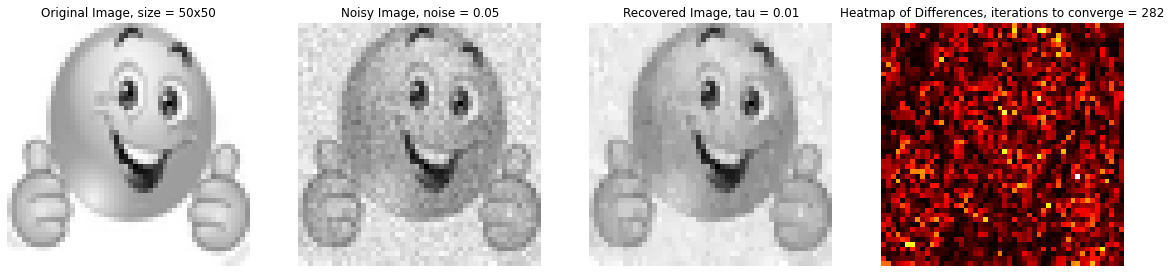

In [ ]:
filenames = ['smile.jpeg']
sizes = [(50, 50)]
noises = 0.05
taus = 0.01
plot_multiple_from_file(filenames, sizes = sizes, noises = noises, taus = taus)

Streaming output truncated to the last 5000 lines.
 max entry in new_X: 1.0080992688123471
 max entry in new_Z: 1.0080992688237542
Xchange: 8.397480656693174e-10
Zchange: 8.465553611970432e-10
4317
 max entry in new_X: 1.0080992688122465
 max entry in new_Z: 1.008099268823629
Xchange: 8.384959735472662e-10
Zchange: 8.452932683672331e-10
4318
 max entry in new_X: 1.008099268812146
 max entry in new_Z: 1.008099268823504
Xchange: 8.372458512577264e-10
Zchange: 8.440328623479842e-10
4319
 max entry in new_X: 1.0080992688120456
 max entry in new_Z: 1.0080992688233792
Xchange: 8.359977298930973e-10
Zchange: 8.427746290182939e-10
4320
 max entry in new_X: 1.0080992688119454
 max entry in new_Z: 1.0080992688232546
Xchange: 8.347512859489442e-10
Zchange: 8.415181320648747e-10
4321
 max entry in new_X: 1.0080992688118458
 max entry in new_Z: 1.0080992688231305
Xchange: 8.335069330403117e-10
Zchange: 8.402636033519827e-10
4322
 max entry in new_X: 1.008099268811746
 max entry in new_Z: 1.00809926

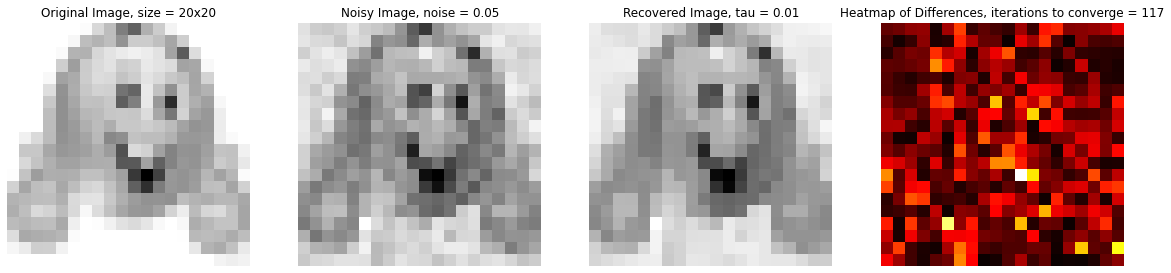

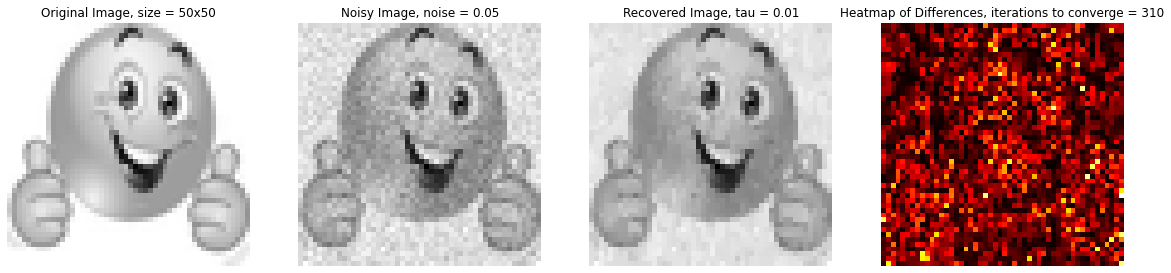

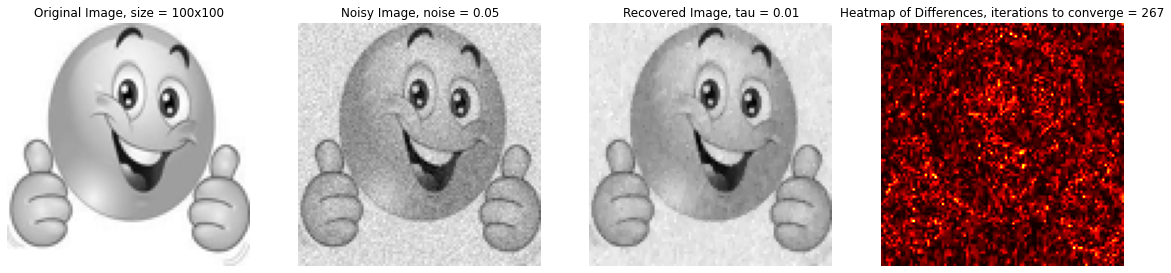

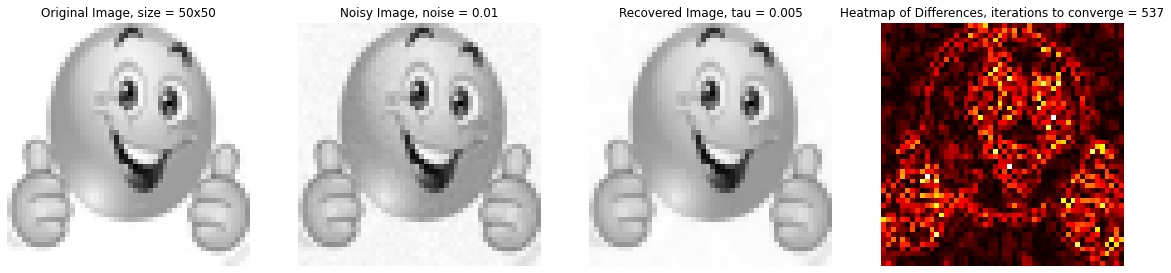

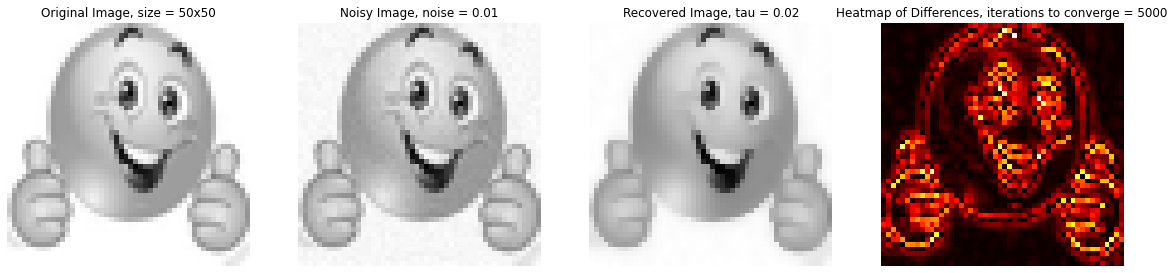

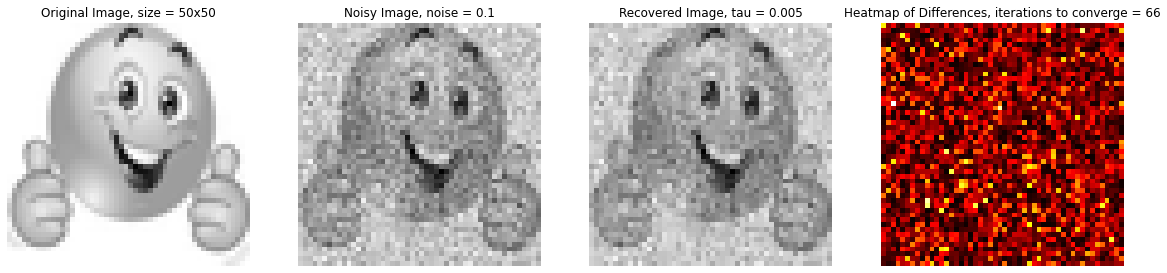

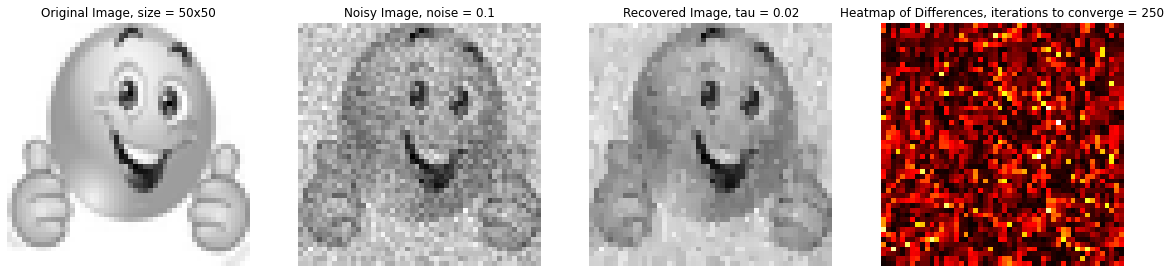

In [ ]:
filenames = ['smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'smile.jpeg']
#you need to upload your own files because it doesn't save across sessions
sizes = [(20, 20), (50, 50), (100, 100), (50, 50), (50, 50), (50, 50), (50, 50)]
noises = [0.05, 0.05, 0.05, 0.01, 0.01, 0.1, 0.1]
taus = [0.01, 0.01, 0.01, 0.005, 0.02, 0.005, 0.02]
#sizes can be left blank to use original size, or an index can be set to none to use original size
#noises can be left blank to default to 0.05, a single number for the same noise over all images,
#or an arrray of noises if you want different noise on images
#taus is the same as noises
plot_multiple_from_file(filenames, sizes = sizes, noises = noises, taus = taus)

Choosing an optimal value of the hyperparameter is unique to each specific image and the properties such as level of noise inherent to the image vs. level of noise added on that needs to be isolated and removed. For these images, we found that $\tau \in [0.01,0.1]$ worked well, although higher values for  $\tau$ seemed to increase runtimes in some cases. Lower values of $\tau$ failed to prioritize denoising enough, so noisy images were returned. Higher values of $\tau$ also tended to start taking out crucial details like borders and outlines which makes sense as "smoothing" was overprioritized.

Note that the image returned from running ADMM to minimize the objective relevant to denoising an image using anisotropic total variation as the metric for noise present is clearly less noisy or fuzzy than the original noisy image we started with. However, it’s not perfect - much of this can be explained by drawbacks to the choice of metric used. Notice how the algorithm does well to remove noise around areas of the image where the pixel color gradient isn’t very high. This is because anisotropic total variation due to noise versus just due to differences in the actual desired image in these regions is clearly distinguishable. However, this is not true for areas of the image where color is supposed to be changed abruptly such as for borders that outline facial features. Notice the eyebrows, thumb outline, jawline, eyes, etc. are still noisy in the produced image. Metrics of noise can’t perfectly distinguish these borders from noise added; however, some metrics will do better e.g. by giving larger differences in adjacent pixel values less priority in the objective so that borders are more often kept. 
